# 병충해 분석 AI 프로젝트

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
!apt-get install -y fonts-nanum > /dev/null
!fc-cache -fv > /dev/null
!rm -rf ~/.cache/matplotlib > /dev/null
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family = 'NanumBarunGothic')
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import cv2
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
cd /content/drive/MyDrive/data/project02

/content/drive/MyDrive/data/project02


# 0. 압축풀기

In [25]:
# 압축파일 폴더별 정리
import os
import zipfile
with zipfile.ZipFile('data.zip', 'r') as existing_zip: # 압축파일 경로 설정
        existing_zip.extractall(f'data/') #압축을 풀어 폴더에 넣기

## 1. 파일읽기

In [6]:
!ls

data	   train_df_csv.csv	train_plant.npz    val_plant.npz
data.zip   train_plant_5.npz	val_df_csv.csv
pepper.h5  train_plant_all.npz	val_plant_all.npz


In [7]:
import numpy as np
import pandas as pd
import os


train_csv = pd.read_csv('train_df_csv.csv')
val_csv = pd.read_csv('val_df_csv.csv')

print('end')

end


# for문으로 각 작물당 2000개씩 샘플 묶기
- 1 고추
- 2 토마토 삭제
- 3 오이
- 4 양배추 삭제
- 5 배추
- 6 애호박 삭제
- 7 콩 삭제
- 8 무
- 9 파
- 10 호박 삭제

> 총 8개의 작물 (곤충과 겹치는 작물)


In [8]:
tc = train_csv[['image', 'disease', 'crop', 'grow', 'risk', 'points', 'name']]
tc

,image,disease,crop,grow,risk,points,name
0,V006_79_0_00_01_01_13_0_a01_20201102_0000_S01_...,0,1,13,0,"[{'xtl': 1118, 'ytl': 1294, 'xbr': 2900, 'ybr'...",고추_0.정상
1,V006_79_0_00_01_01_13_0_a01_20201102_0002_S01_...,0,1,13,0,"[{'xtl': 1033, 'ytl': 1533, 'xbr': 2829, 'ybr'...",고추_0.정상
2,V006_79_0_00_01_01_13_0_a01_20201103_0001_S01_...,0,1,13,0,"[{'xtl': 484, 'ytl': 1227, 'xbr': 3879, 'ybr':...",고추_0.정상
3,V006_79_0_00_01_01_13_0_a01_20201103_0003_S01_...,0,1,13,0,"[{'xtl': 1241, 'ytl': 103, 'xbr': 2344, 'ybr':...",고추_0.정상
4,V006_79_0_00_01_01_13_0_a05_20201111_0000_S01_...,0,1,13,0,"[{'xtl': 1382, 'ytl': 978, 'xbr': 3226, 'ybr':...",고추_0.정상
...,...,...,...,...,...,...,...
14434,V006_79_1_18_09_03_13_1_0819e_20201117_133.jpg,18,9,13,1,"[{'xtl': 135, 'ytl': 0, 'xbr': 875, 'ybr': 961}]",파_1.질병
14435,V006_79_1_18_09_03_13_1_0819e_20201117_134.jpg,18,9,13,1,"[{'xtl': 293, 'ytl': 0, 'xbr': 520, 'ybr': 961}]",파_1.질병
14436,V006_79_1_18_09_03_13_1_0819e_20201118_137.jpg,18,9,13,1,"[{'xtl': 2, 'ytl': 0, 'xbr': 722, 'ybr': 878}]",파_1.질병
14437,V006_79_1_18_09_03_13_1_0819e_20201118_139.jpg,18,9,13,1,"[{'xtl': 192, 'ytl': 0, 'xbr': 636, 'ybr': 961}]",파_1.질병


In [9]:
tc = train_csv[['image', 'disease', 'crop', 'grow', 'risk', 'points', 'name']]
df = pd.DataFrame(index=range(0,), columns=['image', 'disease', 'crop', 'grow', 'risk', 'points', 'name'])

for i in [1,3,5,8,9]:
    for k in range(19):
        if k == 0:
            tmp = tc[(tc['crop'] == i)&(tc['disease'] == k)][:1000]
            df = pd.concat([df, tmp])
        else:
            tmp = tc[(tc['crop'] == i)&(tc['disease'] == k)][:500]
            df = pd.concat([df, tmp])


train_df = df

In [10]:
train_df = train_df[['image', 'disease', 'crop', 'grow', 'risk']]
train_df.reset_index(drop=True, inplace=True)

In [11]:
train_df

,image,disease,crop,grow,risk
0,V006_79_0_00_01_01_13_0_a01_20201102_0000_S01_...,0,1,13,0
1,V006_79_0_00_01_01_13_0_a01_20201102_0002_S01_...,0,1,13,0
2,V006_79_0_00_01_01_13_0_a01_20201103_0001_S01_...,0,1,13,0
3,V006_79_0_00_01_01_13_0_a01_20201103_0003_S01_...,0,1,13,0
4,V006_79_0_00_01_01_13_0_a05_20201111_0000_S01_...,0,1,13,0
...,...,...,...,...,...
9740,V006_79_1_18_09_03_13_1_0819e_20201117_133.jpg,18,9,13,1
9741,V006_79_1_18_09_03_13_1_0819e_20201117_134.jpg,18,9,13,1
9742,V006_79_1_18_09_03_13_1_0819e_20201118_137.jpg,18,9,13,1
9743,V006_79_1_18_09_03_13_1_0819e_20201118_139.jpg,18,9,13,1


In [12]:
vc = val_csv[['image', 'disease', 'crop', 'grow', 'risk', 'points', 'name']]
vc

,image,disease,crop,grow,risk,points,name
0,V006_79_0_00_01_01_13_0_a01_20201103_0000_S01_...,0,1,13,0,"[{'xtl': 502, 'ytl': 1261, 'xbr': 3781, 'ybr':...",고추_0.정상
1,V006_79_0_00_01_01_13_0_a01_20201103_0002_S01_...,0,1,13,0,"[{'xtl': 817, 'ytl': 1564, 'xbr': 3693, 'ybr':...",고추_0.정상
2,V006_79_0_00_01_01_13_0_a05_20201111_0009_S01_...,0,1,13,0,"[{'xtl': 697, 'ytl': 967, 'xbr': 3797, 'ybr': ...",고추_0.정상
3,V006_79_0_00_01_01_13_0_a05_20201111_0014_S01_...,0,1,13,0,"[{'xtl': 627, 'ytl': 1294, 'xbr': 3783, 'ybr':...",고추_0.정상
4,V006_79_0_00_01_01_13_0_a05_20201111_0024_S01_...,0,1,13,0,"[{'xtl': 1002, 'ytl': 458, 'xbr': 3380, 'ybr':...",고추_0.정상
...,...,...,...,...,...,...,...
9100,V006_79_1_18_09_03_13_3_0819e_20201112_151.jpg,18,9,13,3,"[{'xtl': 308, 'ytl': 468, 'xbr': 542, 'ybr': 1...",파_1.질병
9101,V006_79_1_18_09_03_13_3_0819e_20201127_172.jpg,18,9,13,3,"[{'xtl': 0, 'ytl': 341, 'xbr': 960, 'ybr': 960}]",파_1.질병
9102,V006_79_1_18_09_03_13_3_6734e_20201030_50.jpg,18,9,13,3,"[{'xtl': 79, 'ytl': 2, 'xbr': 433, 'ybr': 960}]",파_1.질병
9103,V006_79_1_18_09_03_13_3_6734e_20201117_48.jpg,18,9,13,3,"[{'xtl': 355, 'ytl': 0, 'xbr': 657, 'ybr': 960}]",파_1.질병


In [13]:
vc = val_csv[['image', 'disease', 'crop', 'grow', 'risk', 'points', 'name']]
df = pd.DataFrame(index=range(0,), columns=['image', 'disease', 'crop', 'grow', 'risk', 'points', 'name'])

for i in [1,3,5,8,9]:
    for k in range(19):
        if k == 0:
            tmp = vc[(vc['crop'] == i)&(vc['disease'] == k)][:1000]
            df = pd.concat([df, tmp])
        else:
            tmp = vc[(vc['crop'] == i)&(vc['disease'] == k)][:500]
            df = pd.concat([df, tmp])


val_df = df

In [14]:
val_df = val_df[['image', 'disease', 'crop', 'grow', 'risk']]
val_df.reset_index(drop=True, inplace=True)
val_df

,image,disease,crop,grow,risk
0,V006_79_0_00_01_01_13_0_a01_20201103_0000_S01_...,0,1,13,0
1,V006_79_0_00_01_01_13_0_a01_20201103_0002_S01_...,0,1,13,0
2,V006_79_0_00_01_01_13_0_a05_20201111_0009_S01_...,0,1,13,0
3,V006_79_0_00_01_01_13_0_a05_20201111_0014_S01_...,0,1,13,0
4,V006_79_0_00_01_01_13_0_a05_20201111_0024_S01_...,0,1,13,0
...,...,...,...,...,...
5862,V006_79_1_18_09_03_13_3_0819e_20201112_151.jpg,18,9,13,3
5863,V006_79_1_18_09_03_13_3_0819e_20201127_172.jpg,18,9,13,3
5864,V006_79_1_18_09_03_13_3_6734e_20201030_50.jpg,18,9,13,3
5865,V006_79_1_18_09_03_13_3_6734e_20201117_48.jpg,18,9,13,3


# x y 데이터셋 제작
- x: train 이미지
- y: train disease 번호

## train

In [ ]:
# 폴더 리스트 가져오기
from glob import glob
from PIL import Image
import numpy as np


X=[]
train_dis = list(train_df['disease'])
train_img = list(train_df['image'])
train_cro = list(train_df['crop'])
path = 'data/project/'


for i in range(len(train_df)):
    img = Image.open(path + str(train_cro[i])+ '/train/' + str(train_dis[i]) + '/' + train_img[i])
    img = img.resize((255, 255)) ## 혹시몰라 한번더 리사이즈
    imgarr = np.array(img)/255 # 스케일링
    X.append(imgarr)

In [ ]:
print(np.shape(X))

(14439, 255, 255, 3)


In [ ]:
y = []
for item in train_df['disease']:
  y.append(item)

In [ ]:
print(np.shape(y))

(14439,)


In [ ]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [ ]:
type(X), type(y)

(list, list)

In [ ]:
# np.array 로 변환해야 작업 가능
X_train = np.array(X)
y_train = np.array(y)

In [ ]:
# npz 파일 제작
np.savez('data/train_plant_all.npz', X=X_train, Y=y_train)

## validation

In [ ]:
# 폴더 리스트 가져오기
from glob import glob
from PIL import Image
import numpy as np


X=[]
val_dis = list(val_df['disease'])
val_img = list(val_df['image'])
val_cro = list(val_df['crop'])
path = 'data/project/'


for i in range(len(val_df)):
    img = Image.open(path + str(val_cro[i])+ '/validation/' + str(val_dis[i]) + '/' + val_img[i])
    img = img.resize((255, 255)) ## 혹시몰라 한번더 리사이즈
    imgarr = np.array(img)/255 # 스케일링
    X.append(imgarr)

In [ ]:
print(np.shape(X))

(9105, 255, 255, 3)


In [ ]:
y = []
for item in val_df['disease']:
  y.append(item)

In [ ]:
print(np.shape(y))

(9105,)


In [ ]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18])

In [ ]:
type(X), type(y)

(list, list)

In [ ]:
# np.array 로 변환해야 작업 가능
X_val = np.array(X)
y_val = np.array(y)

In [ ]:
# npz 파일 제작
np.savez('data/val_plant_all.npz', X=X_val, Y=y_val)

--x값--


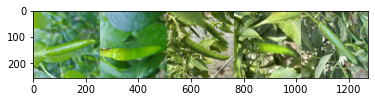

--y value--
[0, 0, 0, 0, 0]


In [ ]:
# 5개의 이미지를 수평으로 나란히 출력
import matplotlib.pyplot as plt

print('--x값--')
plt.imshow(np.hstack(X[:5]))
plt.show()

print('--y value--')
print(y[:5])

In [ ]:
# npz load
import numpy as np

data = np.load('data/train_plant.npz')
data

In [ ]:
list(data)

['X', 'Y']

In [ ]:
X = data['X']
X

array([[[[0.61176471, 0.77647059, 0.04705882],
         [0.54509804, 0.70588235, 0.00784314],
         [0.50588235, 0.66666667, 0.01568627],
         ...,
         [0.54901961, 0.61568627, 0.34901961],
         [0.54901961, 0.60784314, 0.3372549 ],
         [0.5372549 , 0.58823529, 0.31372549]],

        [[0.57647059, 0.7254902 , 0.07843137],
         [0.58039216, 0.7254902 , 0.10588235],
         [0.58431373, 0.7372549 , 0.1372549 ],
         ...,
         [0.60392157, 0.65490196, 0.43529412],
         [0.61176471, 0.66666667, 0.43529412],
         [0.61960784, 0.6627451 , 0.42745098]],

        [[0.61176471, 0.73333333, 0.23529412],
         [0.63529412, 0.76078431, 0.2627451 ],
         [0.63529412, 0.77647059, 0.25882353],
         ...,
         [0.70980392, 0.75294118, 0.59607843],
         [0.71372549, 0.75686275, 0.59215686],
         [0.72156863, 0.75686275, 0.58823529]],

        ...,

        [[0.61568627, 0.78039216, 0.38039216],
         [0.62745098, 0.78823529, 0.41176471]

In [ ]:
y = data['Y']
y

array([0, 0, 0, ..., 2, 2, 2])

## CNN

In [1]:
# 메모리 변수 모두 제거
all = [var for var in globals() if var[0] != '_']
for var in all:
    del globals()[var]

## 사용 패키지

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
!apt-get install -y fonts-nanum > /dev/null
!fc-cache -fv > /dev/null
!rm -rf ~/.cache/matplotlib > /dev/null
mpl.rcParams['axes.unicode_minus'] = False
plt.rc('font', family = 'NanumBarunGothic')
import warnings
warnings.filterwarnings('ignore')

In [6]:
import os
import cv2
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras

## 데이터 로드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/data/project02

/content/drive/MyDrive/data/project02


In [7]:
train_npz = np.load('train_plant_5.npz')
#test_npz = np.load(PATH + 'val_plant_5.npz')
print(list(train_npz))
#print(list(test_npz))

['X', 'Y']


In [8]:
X = train_npz['X']
y = train_npz['Y']

In [9]:
tmp = []
for i in range(len(y)):
  if y[i] == 5.0:
    y[i] = 3.0
  elif y[i] == 6.0:
    y[i] = 4.0
  elif y[i] == 9.0:
    y[i] = 5.0
  elif y[i] == 10.0:
    y[i] = 6.0
  elif y[i] == 13.0:
    y[i] = 7.0
  elif y[i] == 14.0:
    y[i] = 8.0
  elif y[i] == 16.0:
    y[i] = 9.0
  elif y[i] == 17.0:
    y[i] = 10.0
  elif y[i] == 18.0:
    y[i] = 11.0
    

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size = 0.3, random_state = 2021
)

In [11]:
print(np.shape(X_train), len(y_train))
print(np.shape(X_val), len(y_val))

(6821, 255, 255, 3) 6821
(2924, 255, 255, 3) 2924


In [12]:
# y데이터의 분할은 편향없이 잘 되었는가 확인작업

unique, counts = np.unique(y_train, return_counts=True)

unique_yt = dict(zip(unique, counts))
unique_yt

{0.0: 3474,
 1.0: 363,
 2.0: 345,
 3.0: 335,
 4.0: 325,
 5.0: 245,
 6.0: 124,
 7.0: 354,
 8.0: 354,
 9.0: 365,
 10.0: 182,
 11.0: 355}

In [13]:
# y데이터의 분할은 편향없이 잘 되었는가 확인작업

unique, counts = np.unique(y_val, return_counts=True)

unique_yv = dict(zip(unique, counts))
unique_yv

{0.0: 1526,
 1.0: 137,
 2.0: 155,
 3.0: 165,
 4.0: 133,
 5.0: 103,
 6.0: 56,
 7.0: 146,
 8.0: 146,
 9.0: 135,
 10.0: 77,
 11.0: 145}

# 5. CNN
- 컨볼루션 신경망
- 컴퓨터 비전 (Computer Vision) 에서 사용
- 텍스트, 시계열 데이터 등에서도 성능 좋음
- 오버피팅 회피
    - 규제화 함수
        - 가중치 감쇠 (Weight Decay)
        - 모델 복잡도 제한
        - L1, L2 노름, 엘라스틱 넷 (Elastic Net)
        - 기능에 맞춰 가중치 합 구해 손실 함수에 더함
        - tensorflow.keras.regularizers.l1(l = 0.01) : 가중치 절대값 합 (릿지)
        - tensorflow.keras.regularizers.l2(l = 0.01) : 가중치 제곱값 합 (라쏘)
        - tensorflow.keras.regularizers.l1_l2(l1 = 0.01, l2 = 0.01) : 가중치 절대값 합 (릿지) + 가중치 제곱값 합 (라쏘) = (엘라스틱 넷)
    - 드롭 아웃
        - 학습 진행 중 신경망 일부 유닛 제외
        - 테스트 중 작동 하지 않고 모든 유닛 활성화
        - 출력을 드롭 아웃 비율만큼 제외
        - 드롭 아웃 비율 0.2 ~ 0.5
    - 배치 정규화
        - 드롭 아웃과 비교
        - 내부 공선성 (Internal Covariance Shift) 해결 방법
        - 출력값 범위 제한 -> 불확실성 감소 목적
        - 그래디언트 손실, 폭주 없이 높은 학습률 사용 가능
        - 자체적 규제화 효과 포함
        - Dense or Conv2D -> BatchNormalization() -> Activation()

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
model = Sequential()
# (255, 255, 3)
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same',
                 input_shape = (255, 255, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'same',
                 kernel_regularizer = l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same',
                 kernel_regularizer = l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters = 64, kernel_size = 3, padding = 'same',
                 kernel_regularizer = l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same',
                 kernel_regularizer = l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(filters = 128, kernel_size = 3, padding = 'same',
                 kernel_regularizer = l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = 2, padding = 'same'))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, kernel_regularizer = l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(12, activation = 'softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 255, 255, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 255, 255, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 255, 255, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 255, 255, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 255, 255, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 255, 255, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0

In [16]:
model.compile(
    optimizer = Adam(1e-4),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['acc']
)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs = 30,
    batch_size = 32,
    validation_data = (X_val, y_val)
)

Epoch 1/30
 48/214 [=====>........................] - ETA: 7:27 - loss: 2.8558 - acc: 0.4824

## 그래프

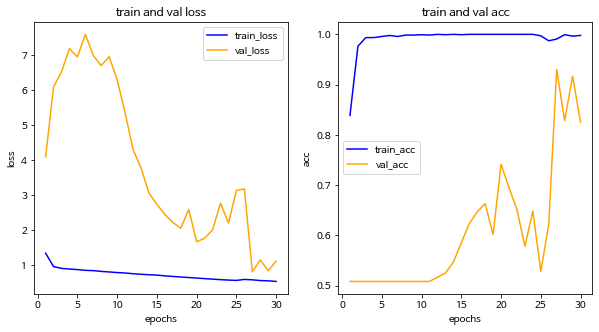

In [ ]:
his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss'] 
epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))
# 훈련, 검증 손실
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()
acc = his_dict['acc']
val_acc = his_dict['val_acc']
# 훈련, 검증 정확도
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()
plt.show()

## h5 저장

In [ ]:
from keras.models import load_model
model.save('pepper.h5')